# 🔬 Analyse Antares — Scénarios EPR
**TP Antares 2040 — Opportunités de décarbonation par les EPR**

Ce notebook charge automatiquement tous les fichiers `.xlsx` Antares du dossier courant,  
extrait les indicateurs clés et génère des graphiques comparatifs.

---
### 📁 Comment utiliser ce notebook
1. Placer ce notebook dans le **même dossier** que vos fichiers Excel Antares
2. Nommer les fichiers avec le nombre d'EPR dans le nom (ex: `14_reacteurs.xlsx`, `12_reacteurs.xlsx`...)
3. Renseigner le dictionnaire `NOMS_SCENARIOS` si besoin
4. Exécuter toutes les cellules (`Run All`)

## ⚙️ 0. Configuration & imports

In [3]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Style graphiques
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': '#F8F9FA',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'font.family': 'sans-serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})

# ============================================================
# CONFIGURATION — à modifier selon vos fichiers
# ============================================================
DOSSIER_EXCEL = "."   # dossier des fichiers xlsx (. = dossier courant)

# Noms personnalisés (optionnel) — clé = nom de fichier, valeur = nom affiché
NOMS_SCENARIOS = {
    "16_reacteurs.xlsx": "16 EPR",
    "14_reaccteurs.xlsx": "14 EPR (référence)",
    "12_reacteurs.xlsx":  "12 EPR",
    "10_reacteurs.xlsx":  "10 EPR",
    "8_reacteurs.xlsx":   "8 EPR",
}
print('✅ Configuration OK')

✅ Configuration OK


## 📥 1. Chargement des données

In [4]:
# Indicateurs à extraire
INDICATEURS = [
    ("('LOLD', 'Hours', 'EXP')",         "sum",  "LOLD",                        "h/an"),
    ("('LOLP', '%', 'values')",           "mean", "LOLP",                        "%"),
    ("('UNSP. ENRG', 'MWh', 'EXP')",     "sum",  "Energie non servie",          "MWh"),
    ("('SPIL. ENRG', 'MWh', 'EXP')",     "sum",  "Spillage EnR",                "MWh"),
    ("('CO2 EMIS.', 'Tons', 'EXP')",     "sum",  "Emissions CO2",               "T"),
    ("('OP. COST', 'Euro', 'EXP')",       "sum",  "OPEX",                        "€"),
    ("('MRG. PRICE', 'Euro', 'EXP')",    "mean", "Prix marginal moyen",         "€/MWh"),
    ("('MRG. PRICE', 'Euro', 'EXP')",    "max",  "Prix marginal max",           "€/MWh"),
    ("('MRG. PRICE', 'Euro', 'EXP')",    "median","Prix marginal médian",       "€/MWh"),
    ("('BALANCE', 'MWh', 'EXP')",        "sum",  "Balance nette (export+)",     "MWh"),
    ("('LOAD', 'MWh', 'EXP')",           "sum",  "Consommation",                "MWh"),
    ("('NUCLEAR', 'MWh', 'EXP')",        "sum",  "Production nucléaire",        "MWh"),
    ("('GAS', 'MWh', 'EXP')",            "sum",  "Production gaz",              "MWh"),
    ("('COAL', 'MWh', 'EXP')",           "sum",  "Production charbon",          "MWh"),
    ("('LIGNITE', 'MWh', 'EXP')",        "sum",  "Production lignite",          "MWh"),
    ("('OIL', 'MWh', 'EXP')",            "sum",  "Production fioul",            "MWh"),
    ("('WIND OFFSHORE', 'MWh', 'EXP')",  "sum",  "Eolien offshore",             "MWh"),
    ("('WIND ONSHORE', 'MWh', 'EXP')",   "sum",  "Eolien onshore",              "MWh"),
    ("('SOLAR PV', 'MWh', 'EXP')",       "sum",  "Solaire PV",                  "MWh"),
    ("('SOLAR ROOFT', 'MWh', 'EXP')",    "sum",  "Solaire toiture",             "MWh"),
    ("('H. ROR', 'MWh', 'EXP')",         "sum",  "Hydraulique fil d'eau",       "MWh"),
    ("('H. STOR', 'MWh', 'EXP')",        "sum",  "Hydraulique stockage",        "MWh"),
]

def lire_excel(filepath):
    """Lit un fichier Excel Antares, retourne (df_annuel, df_horaire)."""
    wb = openpyxl.load_workbook(filepath)
    ws = wb.active
    headers = [cell.value for cell in ws[1]]
    data = list(ws.iter_rows(min_row=2, values_only=True))
    df = pd.DataFrame(data, columns=headers)
    df['datetime'] = pd.to_datetime(df[None], errors='coerce')
    df = df.dropna(subset=['datetime'])
    
    # Extraction indicateurs annuels
    result = {}
    for col, agg, label, unit in INDICATEURS:
        key = f"{label} [{unit}]"
        if col in df.columns:
            series = pd.to_numeric(df[col], errors='coerce')
            if agg == "sum":    result[key] = series.sum()
            elif agg == "mean": result[key] = series.mean()
            elif agg == "max":  result[key] = series.max()
            elif agg == "median": result[key] = series.median()
        else:
            result[key] = np.nan
    
    # Indicateurs dérivés
    prod_totale = sum(result.get(f"{l} [MWh]", 0) or 0 for l in [
        "Production nucléaire", "Production gaz", "Production charbon",
        "Production lignite", "Production fioul",
        "Eolien offshore", "Eolien onshore", "Solaire PV", "Solaire toiture",
        "Hydraulique fil d'eau", "Hydraulique stockage"
    ])
    if prod_totale > 0:
        result["Part nucléaire [%]"] = result.get("Production nucléaire [MWh]", 0) / prod_totale * 100
        fossile = sum(result.get(f"{l} [MWh]", 0) or 0 for l in
                      ["Production gaz", "Production charbon", "Production lignite", "Production fioul"])
        result["Part fossile [%]"] = fossile / prod_totale * 100
        result["Intensité CO2 [gCO2/kWh]"] = (result.get("Emissions CO2 [T]", 0) or 0) * 1000 / prod_totale
    
    return result, df

# Chargement
dossier = Path(DOSSIER_EXCEL)
fichiers = sorted(dossier.glob("*.xlsx"))
print(f"📂 {len(fichiers)} fichier(s) trouvé(s) :")
for f in fichiers:
    print(f"   • {f.name}")

resultats_annuels = {}
resultats_horaires = {}
for f in fichiers:
    nom = NOMS_SCENARIOS.get(f.name, f.stem.replace('_', ' ').replace('reaccteurs', 'EPR').replace('reacteurs', 'EPR'))
    print(f"   ⏳ Lecture {f.name}...", end=" ")
    r, df_h = lire_excel(f)
    resultats_annuels[nom] = r
    resultats_horaires[nom] = df_h
    print("✅")

df_res = pd.DataFrame(resultats_annuels).T
print(f"\n✅ Données chargées pour {len(df_res)} scénario(s)")

📂 6 fichier(s) trouvé(s) :
   • 10 reacteurs.xlsx
   • 12 reacteurs.xlsx
   • 14 reaccteurs.xlsx
   • 16 reacteurs.xlsx
   • 8 reacteurs.xlsx
   • comparaison_scenarios_EPR.xlsx
   ⏳ Lecture 10 reacteurs.xlsx... ✅
   ⏳ Lecture 12 reacteurs.xlsx... ✅
   ⏳ Lecture 14 reaccteurs.xlsx... ✅
   ⏳ Lecture 16 reacteurs.xlsx... ✅
   ⏳ Lecture 8 reacteurs.xlsx... ✅
   ⏳ Lecture comparaison_scenarios_EPR.xlsx... ✅

✅ Données chargées pour 6 scénario(s)


## 📊 2. Tableau de synthèse

In [5]:
cols_synthese = [
    "LOLD [h/an]", "Energie non servie [MWh]", "Spillage EnR [MWh]",
    "Emissions CO2 [T]", "Intensité CO2 [gCO2/kWh]",
    "OPEX [€]", "Prix marginal moyen [€/MWh]", "Prix marginal médian [€/MWh]",
    "Balance nette (export+) [MWh]",
    "Production nucléaire [MWh]", "Production gaz [MWh]",
    "Part nucléaire [%]", "Part fossile [%]"
]
cols_dispo = [c for c in cols_synthese if c in df_res.columns]

def fmt_val(val, col):
    if pd.isna(val): return "—"
    if "€" in col and "MWh" not in col: return f"{val/1e9:.2f} G€"
    if "MWh" in col and val > 1e9: return f"{val/1e9:.2f} TWh"
    if "MWh" in col and val > 1e6: return f"{val/1e6:.1f} TWh"
    if "MWh" in col and val > 1e3: return f"{val/1e3:.0f} GWh"
    if "%" in col: return f"{val:.1f}%"
    if "gCO2" in col: return f"{val:.1f}"
    return f"{val:,.1f}"

df_display = df_res[cols_dispo].copy()
for col in df_display.columns:
    df_display[col] = df_display[col].apply(lambda v: fmt_val(v, col))

display(df_display.T.style.set_properties(**{
    'text-align': 'right', 'font-size': '12px'
}).set_table_styles([{
    'selector': 'th', 
    'props': [('background-color', '#2C3E50'), ('color', 'white'), 
              ('font-weight', 'bold'), ('text-align', 'center')]
}]))

,10 EPR,12 EPR,14 EPR,16 EPR,8 EPR,comparaison scenarios EPR
LOLD [h/an],8.6,5.0,3.2,1.6,13.2,—
Energie non servie [MWh],61 GWh,34 GWh,22 GWh,9 GWh,106 GWh,—
Spillage EnR [MWh],1.9 TWh,2.2 TWh,2.4 TWh,2.7 TWh,1.7 TWh,—
Emissions CO2 [T],"6,844,307.0","6,479,600.0","6,103,850.0","5,687,939.0","7,196,649.0",—
Intensité CO2 [gCO2/kWh],9.4,8.7,8.1,7.4,10.1,—
OPEX [€],12.99 G€,13.31 G€,13.58 G€,13.85 G€,12.67 G€,—
Prix marginal moyen [€/MWh],108.3,100.6,94.3,87.7,118.3,—
Prix marginal médian [€/MWh],96.6,92.8,88.9,84.4,100.6,—
Balance nette (export+) [MWh],125.7 TWh,141.8 TWh,156.4 TWh,171.7 TWh,109.3 TWh,—
Production nucléaire [MWh],356.1 TWh,374.3 TWh,391.0 TWh,408.5 TWh,337.8 TWh,—


## 📈 3. Graphiques comparatifs
### 3.1 Sécurité d'approvisionnement — LOLD & énergie non servie

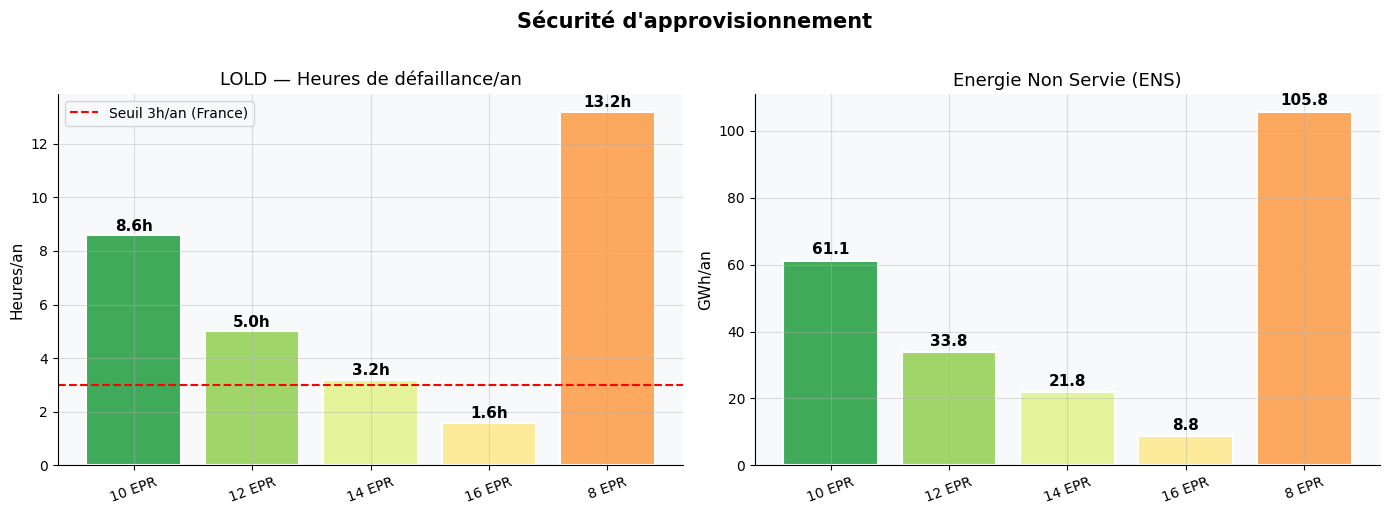

In [6]:
scenarios = list(df_res.index)
colors_scenarios = plt.cm.RdYlGn(np.linspace(0.85, 0.15, len(scenarios)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Sécurité d\'approvisionnement', fontsize=15, fontweight='bold', y=1.02)

# LOLD
ax = axes[0]
vals = df_res["LOLD [h/an]"].values
bars = ax.bar(scenarios, vals, color=colors_scenarios, edgecolor='white', linewidth=1.5)
ax.axhline(3, color='red', linestyle='--', linewidth=1.5, label='Seuil 3h/an (France)')
ax.set_title('LOLD — Heures de défaillance/an')
ax.set_ylabel('Heures/an')
ax.legend()
for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{v:.1f}h', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax.tick_params(axis='x', rotation=20)

# Energie non servie
ax = axes[1]
vals_ens = df_res["Energie non servie [MWh]"].values / 1e3
bars2 = ax.bar(scenarios, vals_ens, color=colors_scenarios, edgecolor='white', linewidth=1.5)
ax.set_title('Energie Non Servie (ENS)')
ax.set_ylabel('GWh/an')
for bar, v in zip(bars2, vals_ens):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(vals_ens)*0.01,
            f'{v:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig('fig_securite.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Mix de production par scénario (graphique empilé)

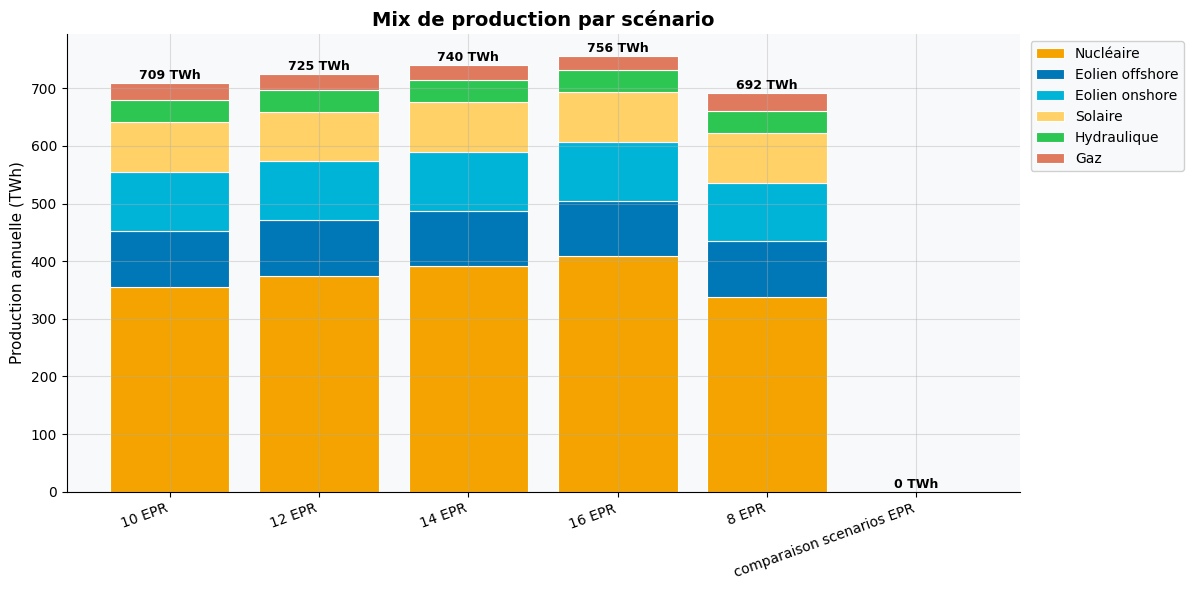

In [7]:
sources_mix = {
    'Nucléaire':          ('Production nucléaire [MWh]',    '#F4A300'),
    'Eolien offshore':    ('Eolien offshore [MWh]',         '#0077B6'),
    'Eolien onshore':     ('Eolien onshore [MWh]',          '#00B4D8'),
    'Solaire':            ('Solaire PV [MWh]',              '#FFD166'),
    'Hydraulique':        ("Hydraulique fil d'eau [MWh]",   '#2DC653'),
    'Gaz':                ('Production gaz [MWh]',          '#E07A5F'),
    'Charbon/Lignite':    ('Production charbon [MWh]',      '#6D6875'),
    'Fioul':              ('Production fioul [MWh]',        '#3D405B'),
}

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(scenarios))
bottom = np.zeros(len(scenarios))

for label, (col, color) in sources_mix.items():
    if col in df_res.columns:
        vals = df_res[col].fillna(0).values / 1e6  # en TWh
        if vals.sum() > 0:
            ax.bar(x, vals, bottom=bottom, label=label, color=color,
                   edgecolor='white', linewidth=0.8)
            bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=20, ha='right')
ax.set_ylabel('Production annuelle (TWh)')
ax.set_title('Mix de production par scénario', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1), framealpha=0.9)

# Valeur totale au-dessus de chaque barre
for i, s in enumerate(scenarios):
    ax.text(i, bottom[i] + 2, f'{bottom[i]:.0f} TWh',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_mix_production.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Emissions CO2 & intensité carbone

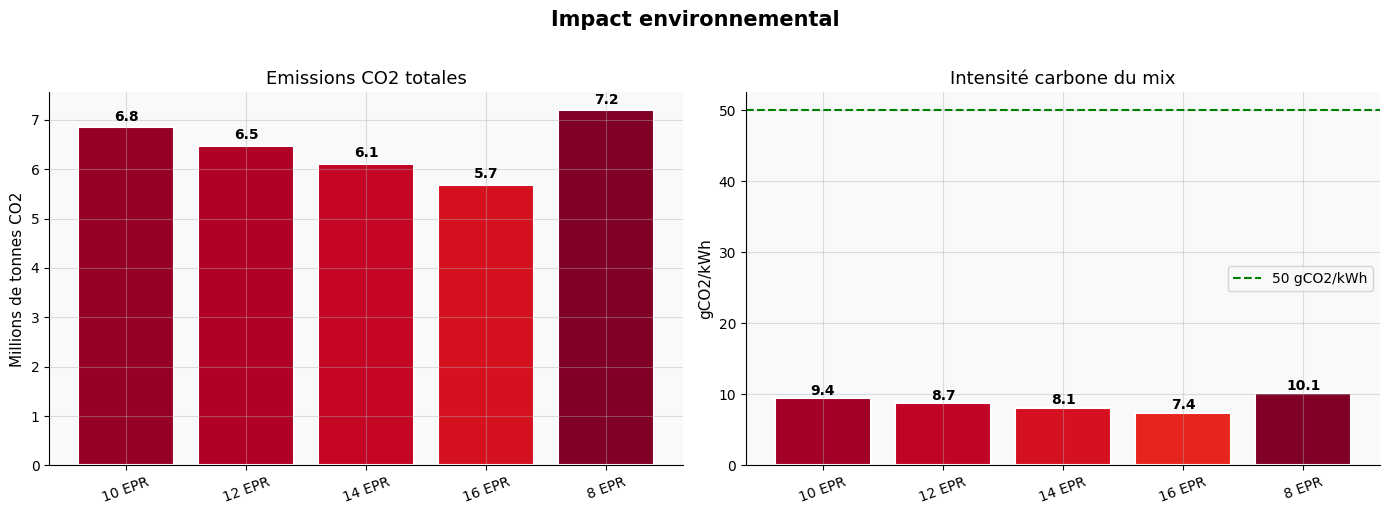

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Impact environnemental', fontsize=15, fontweight='bold', y=1.02)

color_co2 = '#2D6A4F'

# Emissions CO2 totales
ax = axes[0]
vals = df_res["Emissions CO2 [T]"].values / 1e6
bars = ax.bar(scenarios, vals, color=[plt.cm.YlOrRd(v/max(vals+0.001)) for v in vals],
              edgecolor='white', linewidth=1.5)
ax.set_title('Emissions CO2 totales')
ax.set_ylabel('Millions de tonnes CO2')
for bar, v in zip(bars, vals):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals)*0.01,
            f'{v:.1f}', ha='center', va='bottom', fontweight='bold')
ax.tick_params(axis='x', rotation=20)

# Intensité CO2
ax = axes[1]
if "Intensité CO2 [gCO2/kWh]" in df_res.columns:
    vals2 = df_res["Intensité CO2 [gCO2/kWh]"].values
    bars2 = ax.bar(scenarios, vals2, color=[plt.cm.YlOrRd(v/max(vals2+0.001)) for v in vals2],
                   edgecolor='white', linewidth=1.5)
    ax.axhline(50, color='green', linestyle='--', linewidth=1.5, label='50 gCO2/kWh')
    ax.set_title('Intensité carbone du mix')
    ax.set_ylabel('gCO2/kWh')
    ax.legend()
    for bar, v in zip(bars2, vals2):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals2)*0.01,
                f'{v:.1f}', ha='center', va='bottom', fontweight='bold')
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig('fig_co2.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Coûts opérationnels (OPEX) & prix marginal

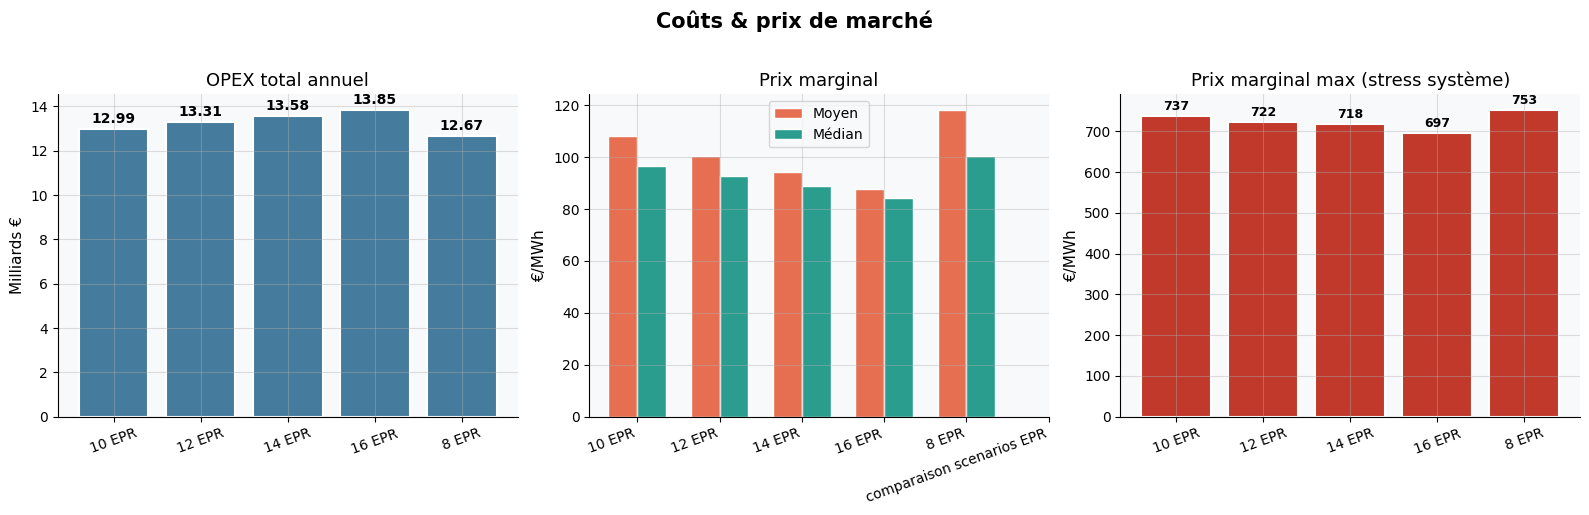

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Coûts & prix de marché', fontsize=15, fontweight='bold', y=1.02)

# OPEX
ax = axes[0]
vals = df_res["OPEX [€]"].values / 1e9
bars = ax.bar(scenarios, vals, color='#457B9D', edgecolor='white', linewidth=1.5)
ax.set_title('OPEX total annuel')
ax.set_ylabel('Milliards €')
for bar, v in zip(bars, vals):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals)*0.01,
            f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
ax.tick_params(axis='x', rotation=20)

# Prix marginal moyen vs médian
ax = axes[1]
w = 0.35
x = np.arange(len(scenarios))
moy = df_res["Prix marginal moyen [€/MWh]"].values
med = df_res["Prix marginal médian [€/MWh]"].values
ax.bar(x - w/2, moy, w, label='Moyen', color='#E76F51', edgecolor='white')
ax.bar(x + w/2, med, w, label='Médian', color='#2A9D8F', edgecolor='white')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=20, ha='right')
ax.set_title('Prix marginal')
ax.set_ylabel('€/MWh')
ax.legend()

# Prix max (stress du système)
ax = axes[2]
vals_max = df_res["Prix marginal max [€/MWh]"].values
bars = ax.bar(scenarios, vals_max, color='#C0392B', edgecolor='white', linewidth=1.5)
ax.set_title('Prix marginal max (stress système)')
ax.set_ylabel('€/MWh')
ax.tick_params(axis='x', rotation=20)
for bar, v in zip(bars, vals_max):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals_max)*0.01,
            f'{v:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('fig_couts.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.5 Balance des échanges & Spillage EnR

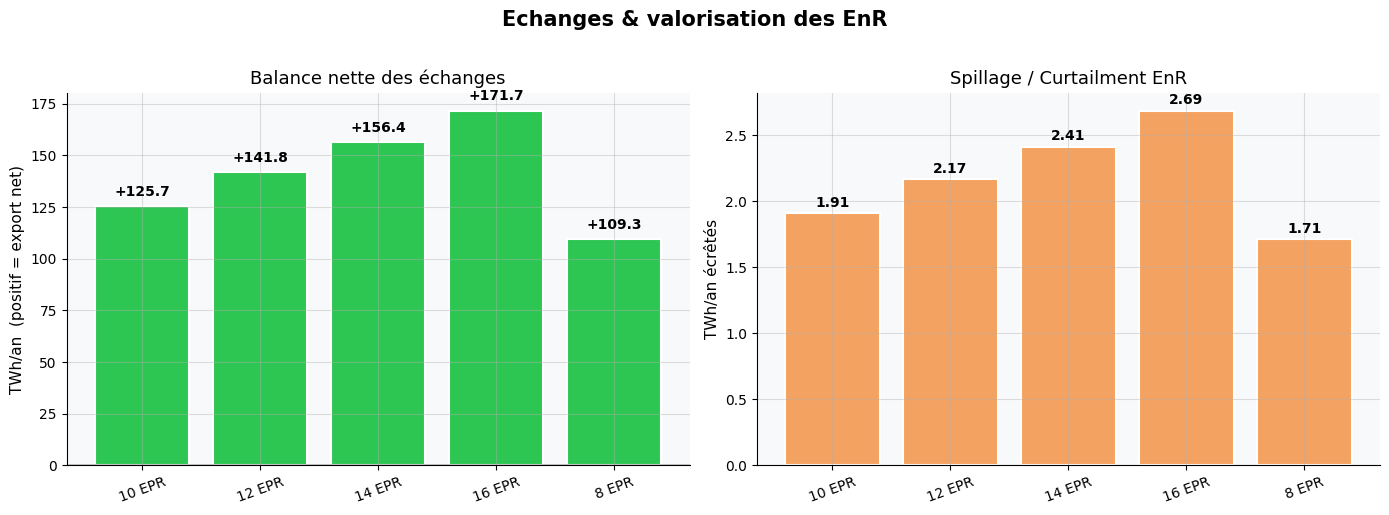

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Echanges & valorisation des EnR', fontsize=15, fontweight='bold', y=1.02)

# Balance
ax = axes[0]
vals = df_res["Balance nette (export+) [MWh]"].values / 1e6
colors_bal = ['#2DC653' if v >= 0 else '#E63946' for v in vals]
bars = ax.bar(scenarios, vals, color=colors_bal, edgecolor='white', linewidth=1.5)
ax.axhline(0, color='black', linewidth=1)
ax.set_title('Balance nette des échanges')
ax.set_ylabel('TWh/an  (positif = export net)')
for bar, v in zip(bars, vals):
    offset = max(abs(vals))*0.02
    va = 'bottom' if v >= 0 else 'top'
    y = v + offset if v >= 0 else v - offset
    ax.text(bar.get_x()+bar.get_width()/2, y,
            f'{v:+.1f}', ha='center', va=va, fontweight='bold')
ax.tick_params(axis='x', rotation=20)

# Spillage
ax = axes[1]
vals_sp = df_res["Spillage EnR [MWh]"].values / 1e6
bars2 = ax.bar(scenarios, vals_sp, color='#F4A261', edgecolor='white', linewidth=1.5)
ax.set_title('Spillage / Curtailment EnR')
ax.set_ylabel('TWh/an écrêtés')
for bar, v in zip(bars2, vals_sp):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(vals_sp)*0.01,
            f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig('fig_echanges.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.6 Distribution horaire du prix marginal (courbe de durée)

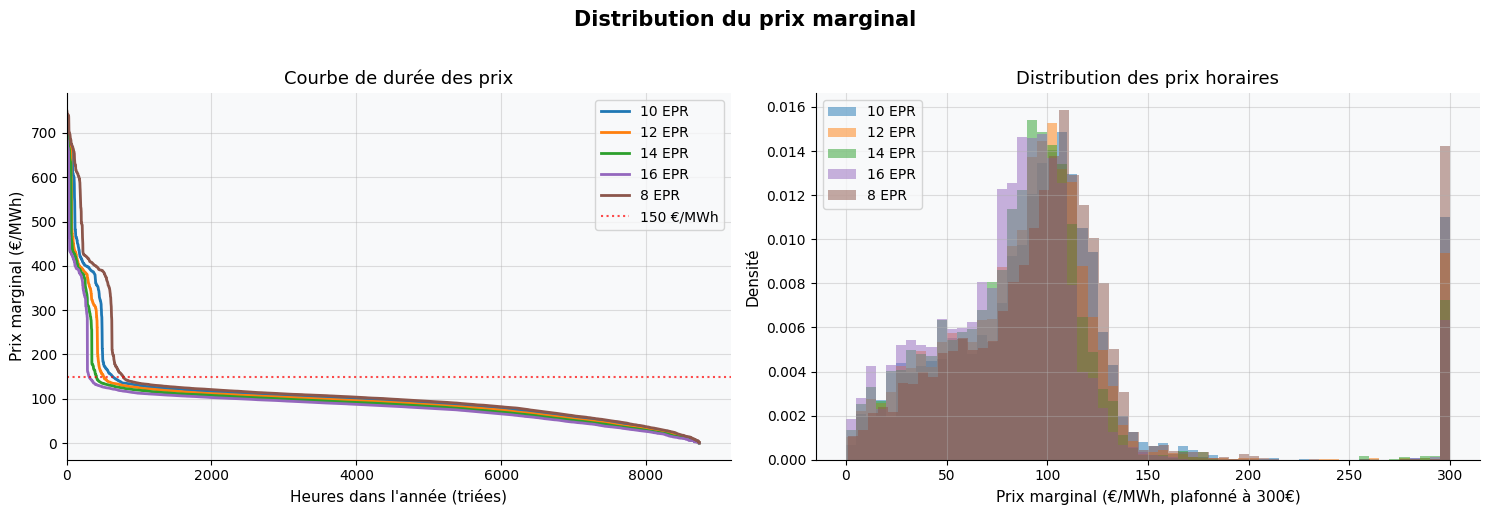

In [11]:
mrg_col = "('MRG. PRICE', 'Euro', 'EXP')"

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribution du prix marginal', fontsize=15, fontweight='bold', y=1.02)

colors_sc = plt.cm.tab10(np.linspace(0, 0.7, len(scenarios)))

for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    if mrg_col not in df_h.columns:
        continue
    prices = pd.to_numeric(df_h[mrg_col], errors='coerce').dropna().sort_values(ascending=False)
    
    # Courbe de durée
    axes[0].plot(np.arange(len(prices)), prices.values, 
                 label=scenario, color=colors_sc[i], linewidth=2)
    
    # Histogramme (distribution)
    axes[1].hist(prices.clip(upper=300), bins=60, alpha=0.5, 
                 label=scenario, color=colors_sc[i], density=True)

axes[0].set_xlabel('Heures dans l\'année (triées)')
axes[0].set_ylabel('Prix marginal (€/MWh)')
axes[0].set_title('Courbe de durée des prix')
axes[0].set_xlim(0)
axes[0].axhline(150, color='red', linestyle=':', alpha=0.7, label='150 €/MWh')
axes[0].legend()

axes[1].set_xlabel('Prix marginal (€/MWh, plafonné à 300€)')
axes[1].set_ylabel('Densité')
axes[1].set_title('Distribution des prix horaires')
axes[1].legend()

plt.tight_layout()
plt.savefig('fig_prix_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.7 Profil saisonnier — Nucléaire & Gaz (MW moyen par mois)

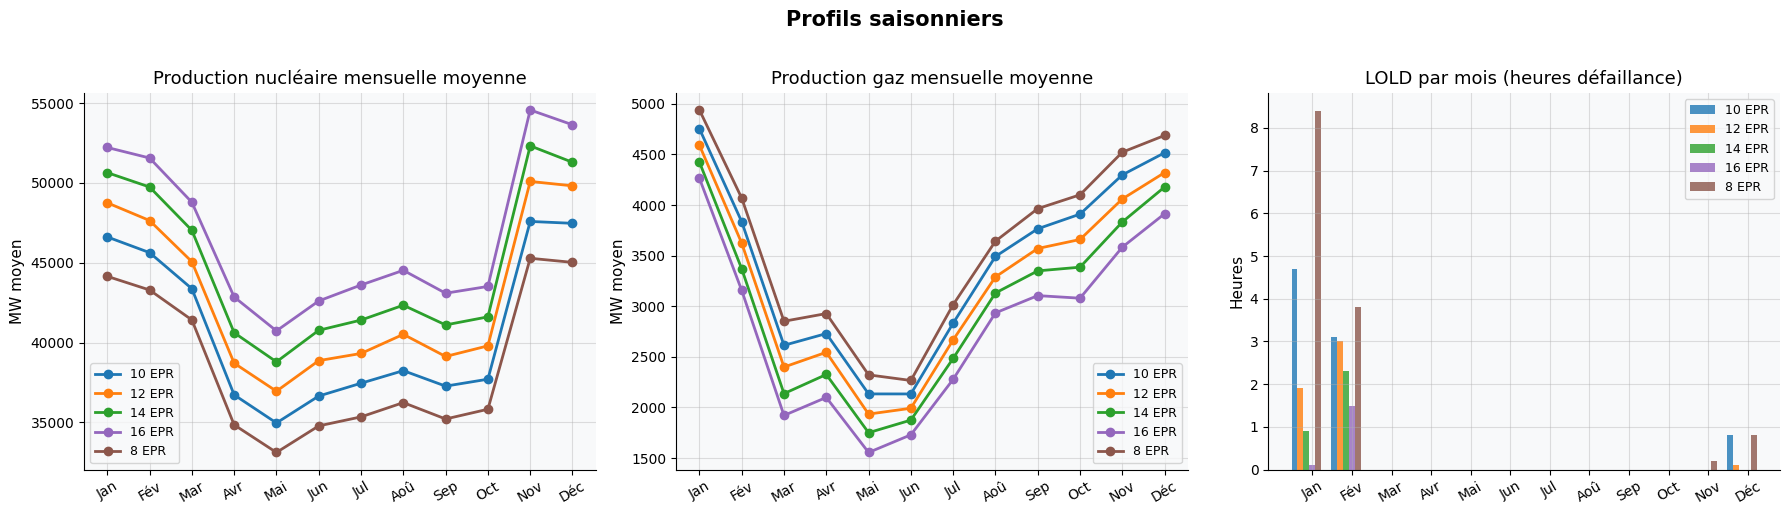

In [12]:
nuc_col  = "('NUCLEAR', 'MWh', 'EXP')"
gas_col  = "('GAS', 'MWh', 'EXP')"
lold_col = "('LOLD', 'Hours', 'EXP')"
mois_labels = ['Jan','Fév','Mar','Avr','Mai','Jun','Jul','Aoû','Sep','Oct','Nov','Déc']
colors_sc = plt.cm.tab10(np.linspace(0, 0.7, len(scenarios)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Profils saisonniers', fontsize=15, fontweight='bold', y=1.02)

for i, (scenario, df_h) in enumerate(resultats_horaires.items()):
    df_h['month'] = pd.to_datetime(df_h['datetime']).dt.month
    
    if nuc_col in df_h.columns:
        nuc_monthly = pd.to_numeric(df_h[nuc_col], errors='coerce').groupby(df_h['month']).mean()
        axes[0].plot(mois_labels, nuc_monthly.values, 'o-', label=scenario,
                     color=colors_sc[i], linewidth=2, markersize=6)
    
    if gas_col in df_h.columns:
        gas_monthly = pd.to_numeric(df_h[gas_col], errors='coerce').groupby(df_h['month']).mean()
        axes[1].plot(mois_labels, gas_monthly.values, 'o-', label=scenario,
                     color=colors_sc[i], linewidth=2, markersize=6)
    
    if lold_col in df_h.columns:
        lold_monthly = pd.to_numeric(df_h[lold_col], errors='coerce').groupby(df_h['month']).sum()
        axes[2].bar(np.arange(12) + i * 0.15 - len(scenarios)*0.075,
                    lold_monthly.reindex(range(1,13), fill_value=0).values,
                    width=0.15, label=scenario, color=colors_sc[i], alpha=0.8)

axes[0].set_title('Production nucléaire mensuelle moyenne')
axes[0].set_ylabel('MW moyen')
axes[0].legend(fontsize=9)
axes[0].tick_params(axis='x', rotation=30)

axes[1].set_title('Production gaz mensuelle moyenne')
axes[1].set_ylabel('MW moyen')
axes[1].legend(fontsize=9)
axes[1].tick_params(axis='x', rotation=30)

axes[2].set_xticks(np.arange(12))
axes[2].set_xticklabels(mois_labels, rotation=30)
axes[2].set_title('LOLD par mois (heures défaillance)')
axes[2].set_ylabel('Heures')
axes[2].legend(fontsize=9)

plt.tight_layout()
plt.savefig('fig_saisonniers.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.8 Radar — Vue globale multi-critères

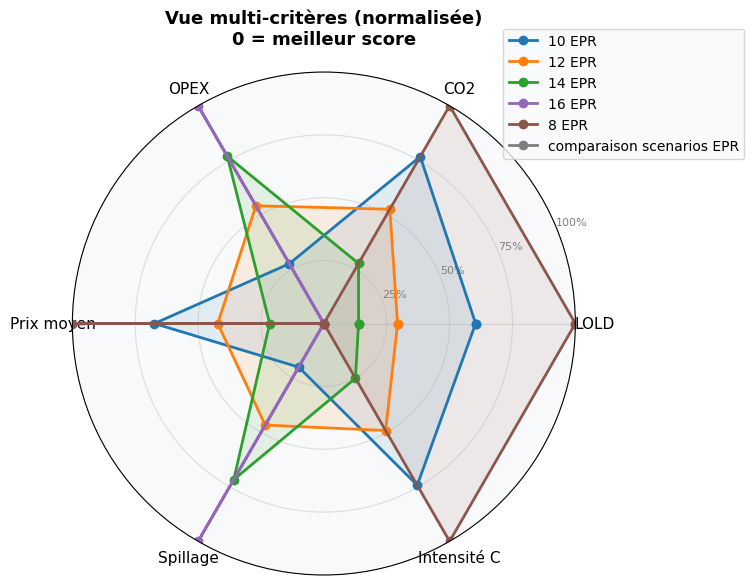

In [13]:
# Normalisation pour radar (0 = meilleur, 1 = pire)
radar_metrics = {
    'LOLD':         ('LOLD [h/an]', True),     # True = plus haut = pire
    'CO2':          ('Emissions CO2 [T]', True),
    'OPEX':         ('OPEX [€]', True),
    'Prix moyen':   ('Prix marginal moyen [€/MWh]', True),
    'Spillage':     ('Spillage EnR [MWh]', True),
    'Intensité C':  ('Intensité CO2 [gCO2/kWh]', True),
}

# Vérification colonnes disponibles
radar_metrics = {k: v for k, v in radar_metrics.items() if v[0] in df_res.columns}
labels_radar = list(radar_metrics.keys())
N = len(labels_radar)

if N >= 3:
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_title('Vue multi-critères (normalisée)\n0 = meilleur score', 
                 fontsize=13, fontweight='bold', pad=20)

    colors_sc = plt.cm.tab10(np.linspace(0, 0.7, len(scenarios)))

    for i, scenario in enumerate(scenarios):
        vals_norm = []
        for metric, (col, higher_worse) in radar_metrics.items():
            col_vals = df_res[col].values.astype(float)
            mn, mx = np.nanmin(col_vals), np.nanmax(col_vals)
            v = df_res.loc[scenario, col]
            if mx > mn:
                norm = (v - mn) / (mx - mn)
            else:
                norm = 0
            vals_norm.append(norm if higher_worse else 1 - norm)
        
        vals_norm += vals_norm[:1]
        ax.plot(angles, vals_norm, 'o-', color=colors_sc[i], linewidth=2, label=scenario)
        ax.fill(angles, vals_norm, alpha=0.1, color=colors_sc[i])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels_radar, size=11)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['25%', '50%', '75%', '100%'], size=8, color='grey')
    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1))

    plt.tight_layout()
    plt.savefig('fig_radar.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('⚠️ Pas assez de métriques disponibles pour le radar.')

## 💾 4. Export Excel de synthèse

In [14]:
output_path = Path(DOSSIER_EXCEL) / 'comparaison_scenarios_EPR.xlsx'

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # Valeurs absolues (toutes les colonnes)
    df_res.T.to_excel(writer, sheet_name='Valeurs absolues')
    
    # Deltas % vs référence
    ref = df_res.index[0]
    df_delta = df_res.copy()
    for col in df_res.columns:
        ref_val = df_res.loc[ref, col]
        if pd.notna(ref_val) and ref_val != 0:
            df_delta[col] = ((df_res[col] - ref_val) / abs(ref_val) * 100).round(2)
    df_delta.T.to_excel(writer, sheet_name=f'Delta % vs {ref[:20]}')
    
    # Synthèse indicateurs clés
    cols_cles = [c for c in [
        "LOLD [h/an]", "Energie non servie [MWh]", "Spillage EnR [MWh]",
        "Emissions CO2 [T]", "Intensité CO2 [gCO2/kWh]", "OPEX [€]",
        "Prix marginal moyen [€/MWh]", "Balance nette (export+) [MWh]",
        "Production nucléaire [MWh]", "Production gaz [MWh]",
        "Part nucléaire [%]", "Part fossile [%]"
    ] if c in df_res.columns]
    df_res[cols_cles].T.to_excel(writer, sheet_name='Synthèse clés')

print(f'✅ Fichier exporté : {output_path.resolve()}')

✅ Fichier exporté : /mnt/c/Users/fbazon/TP/antares/comparaison_scenarios_EPR.xlsx
